# Exercise 7: Variational Monte Carlo simulation of trapped ions

**Goal:** Approximate the ground-state energy and density profile of N trapped one-dimensional charges

**Model:**

The Hamiltonian of $N$ ions of charge $q$ and mass $m$ interacting via repulsive Coulomb $q^2/|x|$ potential and confined to a one-dimensional harmonic oscillator with frequency $\omega$ is given by

$$\hat{H} = -\frac{\hbar^2}{2m} \sum_{i=1}^{N} \frac{\partial^2}{\partial x_i^2} + \frac{m\omega^2}{2} \sum_{i=1}^{N} x_i^2 + \sum_{i<j} \frac{q^2}{|x_i - x_j|} \tag{2.1}$$

It is convenient to choose oscillator length $a_{ho} = \sqrt{\hbar/m\omega}$ as a unit of length and harmonic oscillator level spacing $\hbar\omega$ as a unit of energy. With this choice, one can recover the limits of vanishing interaction potential $q \to 0$. The Hamiltonian in dimensionless units reads as

$$\hat{H} = -\frac{1}{2} \sum_{i=1}^{N} \frac{\partial^2}{\partial x_i^2} + \frac{1}{2} \sum_{i=1}^{N} x_i^2 + \sum_{i>j} \frac{\tilde{q}^2}{|x_i - x_j|} \tag{2.2}$$

where $\tilde{q}$ is the dimensionless charge. 

The variational wave function of the ground state can be written in product form (Jastrow-style trial wave function):

$$\psi(x_1, \dots, x_N) = \prod_{i<j} |x_i - x_j|^\lambda \prod_{k} e^{-\alpha x_k^2} \tag{2.3}$$

where $\alpha$ and $\lambda$ are free parameters.
- The Gaussian term ($\alpha$) handles the trapping.
- The Jastrow term ($\lambda$) creates a "hole" when two particles approach, preventing the energy from diverging due to the $1/x$ potential.

Note that for $\lambda > 0$, the wave function vanishes whenever any two charges meet each other. This is physically correct, as in one dimension, the integral $\int dx/x$ of the Coulomb potential diverges logarithmically, so a finite probability of finding two charges together would result in infinite energy.

The variational energy $E_{VMC}$ provides an upper bound to the ground state energy $E_0$, that is, $E_{VMC} \geq E_0$ with the equality sign being fulfilled only when the variational wave function coincides with the exact ground state wave function.

The variational principle can be used to optimize the values of the variational parameters by minimizing the variational energy.

**Trick to compute the Local Energy:**

One "trick" widely used in Variational Monte Carlo to make many-body calculations efficient is to work with the logarithm of the wave function:

$$\ln \Psi_T = \sum_{i<j} \lambda \ln |x_i - x_j| - \sum_{k=1}^N \alpha x_k^2$$

As in homework 6, to evaluate the expectation value of the Hamiltonian $\langle \hat{H} \rangle = \int P(R) E_L(R) dR$, we use two statistically different but mathematically equivalent estimators for the local kinetic energy. This serves as a self-consistency check for our code.

1. Laplacian Estimator

This is the direct evaluation of the local energy:

$$E_L^{Lap} = \frac{1}{\Psi_T} \hat{H} \Psi_T = V(R) - \frac{1}{2} \sum_{i=1}^N \frac{\nabla_i^2 \Psi_T}{\Psi_T}$$

By using the identity $\frac{\nabla^2 \Psi}{\Psi} = \nabla^2 \ln \Psi + (\nabla \ln \Psi)^2$, we compute it efficiently as:

$$E_L^{Lap} = V(R) - \frac{1}{2} \sum_{i=1}^N \left( \frac{\partial^2 \ln \Psi_T}{\partial x_i^2} + \left( \frac{\partial \ln \Psi_T}{\partial x_i} \right)^2 \right)$$

2. Drift Force (Gradient) Estimator

Using integration by parts, it can be shown that the kinetic energy is also related to the square of the "drift force" $\vec{F}_i = \nabla_i \ln \Psi_T$:

$$E_L^{Grad} = V(R) + \frac{1}{2} \sum_{i=1}^N |\vec{F}_i|^2$$

While $E_L^{Lap}$ and $E_L^{Grad}$ differ for any single configuration, their averages over many Monte Carlo steps must converge to the same value. A discrepancy between these two averages indicates a bug in the derivative calculations or a lack of convergence.

For the simulation, we compute explicitly the first and second derivatives of the log of the trial wavefunction: 

$$\frac{\partial \ln \Psi_T}{\partial x_i} = -2\alpha x_i + \lambda \sum_{j \neq i}^N \frac{1}{x_i - x_j}$$

$$\frac{\partial^2 \ln \Psi_T}{\partial x_i^2} = -2\alpha - \lambda \sum_{j \neq i}^N \frac{1}{(x_i - x_j)^2}$$

**Algorithm:**

1. generate a random initial configuration
2. make a loop over Monte Carlo iterations
3. move the point $\mathbf{R} \to \mathbf{R'}$ in the phase space. for example, each particle can be displaced according to a random flat ($r_i \to r_i + (2\xi - 1)\Delta$) or Gaussian ($r_i \to r_i + \xi$) distribution
4. accept or reject the move according to the Metropolis algorithm. For example, throw a random number $\xi \in (0, 1)$ and accept the move if $p(\mathbf{R'})/p(\mathbf{R}) > \xi$.
5. accumulate the local energy and its square ($energy := energy + local\_energy; energy2 = energy2 + local\_energy * local\_energy$); density profile;
6. after $Niter$ iterations are done, estimate the mean energy ($\langle E \rangle \approx energy/Niter$), its variance: $\sigma_E^2 = \langle E^2 - \langle E \rangle^2 \rangle \approx energy2/Niter - (energy/Niter)**2$ and its statistical error $\varepsilon_E = \sigma_E/\sqrt{N_{uncorr}}$ where $N_{uncorr}$ is the number of uncorrelated measurements.

**Tasks:**

Set the number of particles to $N = 10$ and dimensionless charge to $\tilde{q} = 1$.

1. calculate the variational energy as a function of two variational parameters $\alpha$ and $\beta$
2. plot typical dependencies on $\alpha$ and $\beta$
3. find the optimal parameters of $\alpha$ and $\beta$ for which the variational energy reaches its minimal value
4. report the variational result for the ground state energy
5. report the density profile obtained for the optimal parameters


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import time

In [7]:
# HELPER FUNCTIONS

@njit
def local_energy(x, alpha, lmbda, q=1.0):
    """
    Computes the many-body local energy using the Laplacian & Drift Force estimators.
    We set q = 1 (value of dimensionless charge)
    """
    N = len(x)

    # Potential Energy V = trap + int
    v_trap = 0.5 * np.sum(x**2)
    v_int = 0.0
    for i in range(N):
        for j in range(i+1, N):
            dist = np.abs(x[i]-x[j])
            if dist < 1e-12:  # Safety check for singularities
                v_int += 1e10 
            else:
                v_int += (q**2) / dist  # Coulomb repulsion
    
    V = v_trap + v_int

    # Kinetic Energy (two estimators)
    sum_laplacian = 0.0
    sum_drift = 0.0

    for i in range(N):
        # Drift force: grad_i(ln Psi): 1st term
        f_i = -2.0 * alpha * x[i]
        # Laplacian term: div_i(grad_i ln Psi): 1st term
        lap_i = -2.0 * alpha
        
        for j in range(N):
            if i == j: continue
            dist = x[i] - x[j]

            if np.abs(dist) < 1e-12: continue   # Avoid division by zero

            inv_dist = 1.0 / dist
            
            f_i += lmbda * inv_dist
            lap_i -= lmbda * (inv_dist**2)
            
        sum_drift += f_i**2
        sum_laplacian += lap_i + f_i**2
    
    T_lap = -0.5 * sum_laplacian
    T_drift = 0.5 * sum_drift

    return T_lap + V, T_drift + V

@njit
def psi_T(x, alpha, lmbda):
    """
    Many-body trial wave function for N particles.
    x is an array of positions.
    """
    N = len(x)
    # One-body term: product of Gaussians
    one_body = np.exp(-alpha * np.sum(x**2))
    
    # Two-body term: Jastrow product
    two_body = 1.0
    for i in range(N):
        for j in range(i + 1, N):
            two_body *= np.abs(x[i] - x[j])**lmbda
            
    return one_body * two_body

@njit
def log_probability(x, alpha, lmbda):
    """
    Computes ln(|Psi|^2) = -2*alpha*sum(x^2) + 2*lambda*sum(ln|xi-xj|)
    Used to avoid underflow in many-body MC simulations
    """
    N = len(x)
    # Gaussian part: ln(exp(-alpha*x^2)^2) = -2*alpha*x^2
    log_val = -2.0 * alpha * np.sum(x**2)
    
    # Jastrow part: ln(|xi-xj|^lambda^2) = 2*lambda*ln(|xi-xj|)
    for i in range(N):
        for j in range(i + 1, N):
            dist = np.abs(x[i] - x[j])
            if dist < 1e-12: 
                return -1e20 # return huge negative number (effectively -infinity)
            log_val += 2.0 * lmbda * np.log(dist)
            
    return log_val

# MC SIMULATION
@njit
def VMC_simulation(n_steps, N, alpha, lmbda, delta, q=1.0):
    """
    Runs Variational Monte Carlo simulation with Metropolis algorithm.

    Inputs:
        n_steps             : number of MC steps to perform
        N                   : number of particles
        alpha, lmbda        : variational parameters for the trial wavefunction
        delta               : maximum displacement for trial moves
        q                   : dimensionless charge set to 1
    Outputs:
        energies_lap        : energy history (Laplacian estimator)
        energies_grad      : energy history (Drift Force/Gradient estimator)
        acceptance_rate     : acceptance rate per step
        x_history           : history particle positions
    """
    # Storage for results
    energies_lap = np.zeros(n_steps)
    energies_grad = np.zeros(n_steps)
    x_history = np.zeros((n_steps, N))  # 2D array to store N particles per step

    # Initialized positions are spread out to avoid inf repulsion at start
    x = np.linspace(-2.0, 2.0, N)

    accepted = 0

    # Calculate current (log) probability to prevent underflow in many-body simulations
    log_P_current = log_probability(x, alpha, lmbda)

    # MC loop
    for step in range(n_steps):
        # 1. Propose a random move
        x_new = x + delta * (2.0 * np.random.rand(N) - 1.0)

        # 2. Compute new (log) probability
        log_P_new = log_probability(x_new, alpha, lmbda)

        # 3. Metropolis algorithm (Logarithm version)
        # Ratio A = P_new / P_old  ==>  ln(A) = ln(P_new) - ln(P_old)
        # Accept if ln(A) > ln(rand)
        if (log_P_new - log_P_current) > np.log(np.random.rand()):
            x = x_new
            log_P_current = log_P_new
            accepted += 1
        
        # 4. Measure Local Energy
        e_lap, e_grad = local_energy(x, alpha, lmbda, q)
        
        energies_lap[step] = e_lap
        energies_grad[step] = e_grad
        x_history[step, :] = x
        
    return energies_lap, energies_grad, accepted / n_steps, x_history

**Part I:**

Let us find the optimal values for the variational parameters $\alpha$ and $\lambda$ that minimize the ground state energy of the $N=10$ particle trapped ion system.

In order to better educate our selection for the range of the parameters that we are going to analyze, let us plot the depencies of the Local Energy (using the Laplacian estimator) on the parameters by fixing one of them at a time:

Scanning Lambda (fixed alpha=0.5)...
Scanning Alpha (fixed lambda=1.0)...


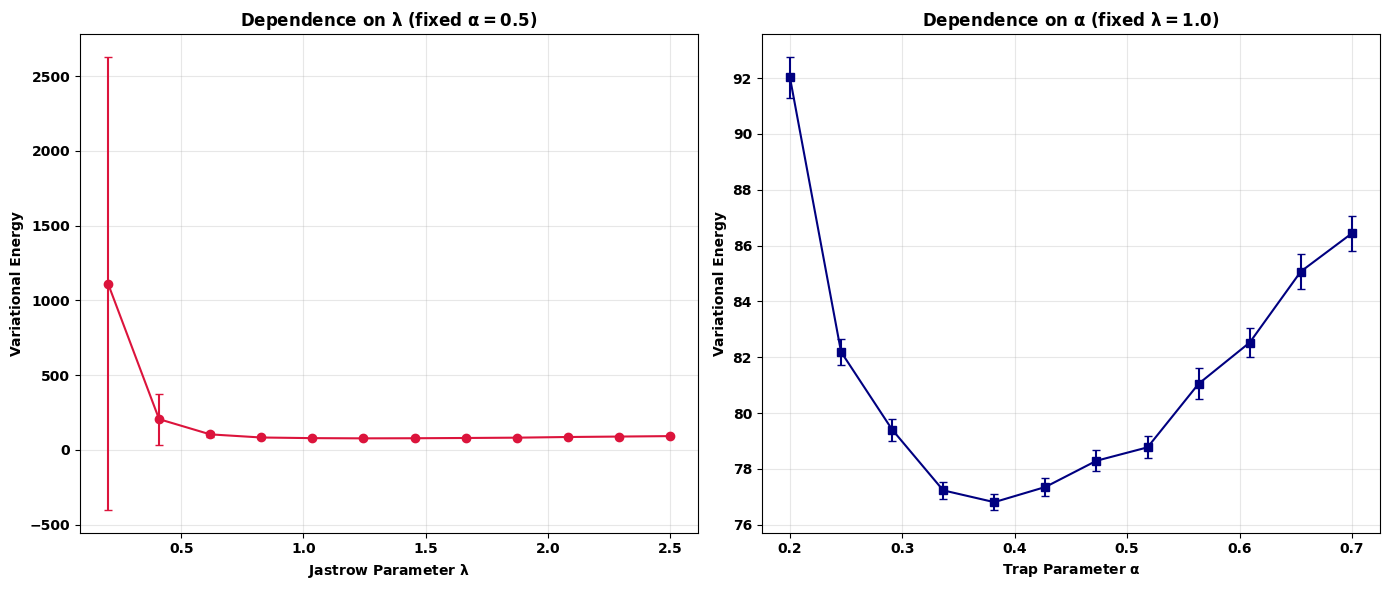

In [ ]:
# Initial parameteres
N_part = 10
q_charge = 1.0
delta = 0.3
n_steps = 5000 

# 1. SCAN LAMBDA (Fixing Alpha)
# We fix alpha = 0.5 (exact value for non-interacting bosons) to see the effect of the lambda
fixed_alpha = 0.5 
lambdas_scan = np.linspace(0.2, 2.5, 12) 
energies_lambda = []
errors_lambda = []

print(f"Scanning Lambda (fixed alpha={fixed_alpha})...")
for l in lambdas_scan:
    e_lap, _, _, _ = VMC_simulation(n_steps, N_part, fixed_alpha, l, delta, q_charge)
    # Discard first 20%
    burn = int(n_steps * 0.2)
    energies_lambda.append(np.mean(e_lap[burn:]))
    errors_lambda.append(np.std(e_lap[burn:]) / np.sqrt((n_steps - burn)/50)) # Approx error

# 2. SCAN ALPHA (Fixing Lambda)
# We fix lambda = 1.0 (linear correlation) to find the best trap width
fixed_lambda = 1.0
alphas_scan = np.linspace(0.2, 0.7, 12)
energies_alpha = []
errors_alpha = []

print(f"Scanning Alpha (fixed lambda={fixed_lambda})...")
for a in alphas_scan:
    e_lap, _, _, _ = VMC_simulation(n_steps, N_part, a, fixed_lambda, delta, q_charge)
    burn = int(n_steps * 0.2)
    energies_alpha.append(np.mean(e_lap[burn:]))
    errors_alpha.append(np.std(e_lap[burn:]) / np.sqrt((n_steps - burn)/50))

# PLOTTING
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Energy vs Lambda
ax[0].errorbar(lambdas_scan, energies_lambda, yerr=errors_lambda, fmt='o-', color='crimson', capsize=3)
ax[0].set_title(f"Dependence on $\\lambda$ (fixed $\\alpha={fixed_alpha}$)")
ax[0].set_xlabel("Jastrow Parameter $\\lambda$")
ax[0].set_ylabel("Variational Energy")
ax[0].grid(True, alpha=0.3)

# Plot 2: Energy vs Alpha
ax[1].errorbar(alphas_scan, energies_alpha, yerr=errors_alpha, fmt='s-', color='navy', capsize=3)
ax[1].set_title(f"Dependence on $\\alpha$ (fixed $\\lambda={fixed_lambda}$)")
ax[1].set_xlabel("Trap Parameter $\\alpha$")
ax[1].set_ylabel("Variational Energy")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Looking at the plots of the Local Energy as a function of the optimization parameters, we can conclude that:
- For $\alpha$ (Trap Width), we will scan the range $[0.30, 0.60]$.
- For $\lambda$ (Interaction Strength), we will scan the range $[0.5, 2.0]$. This parameter creates a "hole" in the wavefunction to counteract the $1/r$ Coulomb singularity. The range under study effectively goes from "soft" ($\lambda=0.5$) to "hard" ($\lambda=2$) repulsion to ensure we get to the minimum energy.

In [26]:
# Definition of the Grids for optimization
alphas = np.linspace(0.30, 0.60, 200) 
lambdas = np.linspace(0.5, 2.0, 200) 
energy_grid = np.zeros((len(alphas), len(lambdas)))

print(f"Starting Grid Search for N={N_part} particles, q={q_charge}...")

# Variables to store the best run found so far
global_min_energy = 1e9  # specific large number
best_params = (0, 0)
best_run_data = {}  # Dictionary to save history of the best run

start_time = time.time()

for i, a in enumerate(alphas):
    for j, l in enumerate(lambdas):
        # Run simulation
        e_lap, e_grad, acc, x_hist = VMC_simulation(n_steps, N_part, a, l, delta, q_charge)
        
        # Calculate mean energy (discarding first 20%)
        valid_E = int(n_steps * 0.2)
        mean_E = np.mean(e_lap[valid_E:])
        
        energy_grid[i, j] = mean_E
        print(f"  alpha={a:.2f}, lambda={l:.2f} -> E = {mean_E:.3f} (Acc: {acc:.2%})")
        if mean_E < global_min_energy:
            global_min_energy = mean_E
            best_params = (a, l)
            # Save the full arrays so we can plot them at the end
            best_run_data = {
                'e_lap': e_lap,
                'e_grad': e_grad,
                'x_history': x_hist,
                'acc': acc
            }

print(f"\nOptimization completed in {time.time()-start_time:.1f}s")

print(f"\n Optimal Parameters: alpha = {best_params[0]:.3f}, lambda = {best_params[1]:.3f}")
print(f"\n Minimum GS Energy: E = {global_min_energy:.4f}")
print(f"Acceptance Rate: {best_run_data['acc']:.2%}")

Starting Grid Search for N=10 particles, q=1.0...
  alpha=0.30, lambda=0.50 -> E = 111.740 (Acc: 45.52%)
  alpha=0.30, lambda=0.51 -> E = 127.709 (Acc: 46.02%)
  alpha=0.30, lambda=0.52 -> E = 121.415 (Acc: 45.24%)
  alpha=0.30, lambda=0.52 -> E = 398.092 (Acc: 44.92%)
  alpha=0.30, lambda=0.53 -> E = 105.165 (Acc: 45.98%)
  alpha=0.30, lambda=0.54 -> E = 89.444 (Acc: 45.80%)
  alpha=0.30, lambda=0.55 -> E = 108.937 (Acc: 45.04%)
  alpha=0.30, lambda=0.55 -> E = 94.825 (Acc: 45.72%)
  alpha=0.30, lambda=0.56 -> E = 105.696 (Acc: 44.48%)
  alpha=0.30, lambda=0.57 -> E = 86.898 (Acc: 47.02%)
  alpha=0.30, lambda=0.58 -> E = 88.307 (Acc: 45.84%)
  alpha=0.30, lambda=0.58 -> E = 88.627 (Acc: 44.96%)
  alpha=0.30, lambda=0.59 -> E = 89.700 (Acc: 43.06%)
  alpha=0.30, lambda=0.60 -> E = 88.321 (Acc: 44.84%)
  alpha=0.30, lambda=0.61 -> E = 90.372 (Acc: 46.12%)
  alpha=0.30, lambda=0.61 -> E = 95.214 (Acc: 44.94%)
  alpha=0.30, lambda=0.62 -> E = 84.345 (Acc: 43.40%)
  alpha=0.30, lambda=0.63

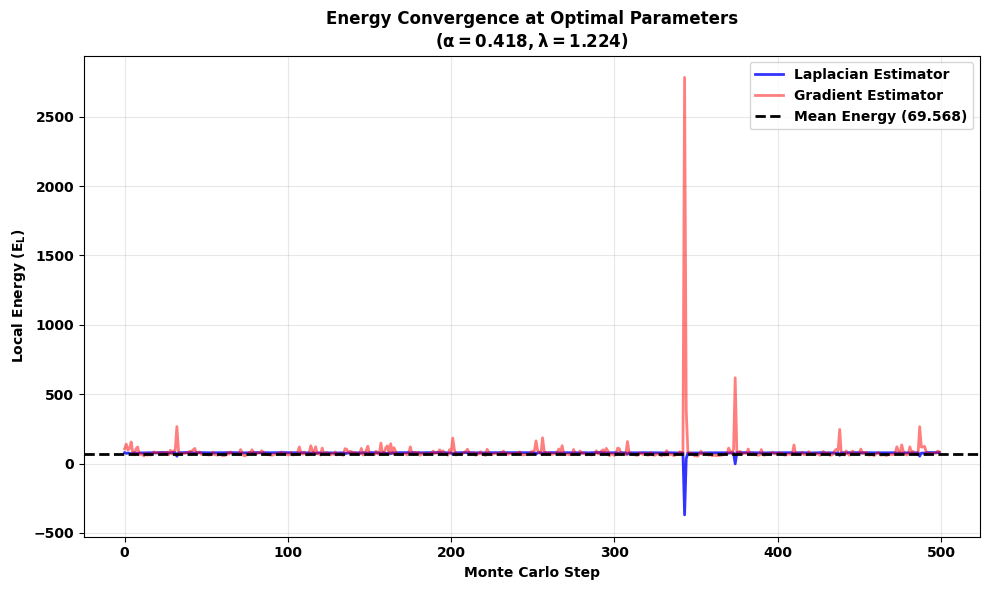

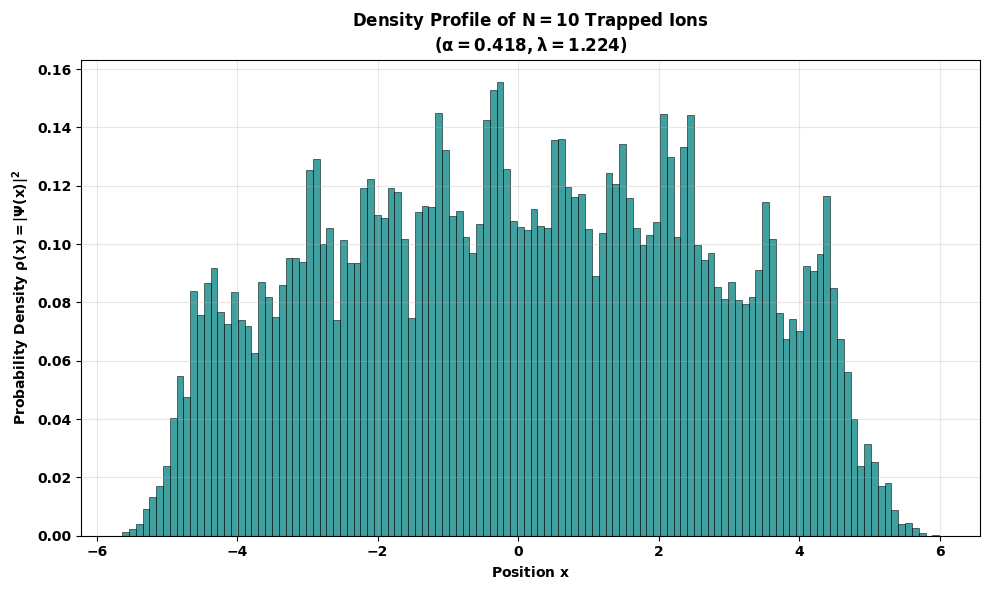

In [27]:
# PLOT: ENERGY CONVERGENCE
plt.figure(figsize=(10, 6))

# Plot traces
plt.plot(best_run_data['e_lap'][::10], label='Laplacian Estimator', alpha=0.8, color='blue', lw=2)
plt.plot(best_run_data['e_grad'][::10], label='Gradient Estimator', alpha=0.5, color='red', lw=2)

# Plot Mean
plt.axhline(global_min_energy, color='k', linestyle='--', linewidth=2, label=f'Mean Energy ({global_min_energy:.3f})')

plt.xlabel("Monte Carlo Step")
plt.ylabel("Local Energy ($E_L$)")
plt.title(f"Energy Convergence at Optimal Parameters\n($\\alpha={best_params[0]:.3f}, \\lambda={best_params[1]:.3f}$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# PLOT: DENSITY PROFILE
plt.figure(figsize=(10, 6))

# Get rid of first 20% of points
burn_in_idx = int(len(best_run_data['e_lap']) * 0.2)
final_positions = best_run_data['x_history'][burn_in_idx:].flatten()

# Plot Histogram
plt.hist(final_positions, bins=120, density=True, color='teal', alpha=0.75, edgecolor='black', linewidth=0.5)

plt.xlabel("Position $x$")
plt.ylabel(r"Probability Density $\rho(x) = |\Psi(x)|^2$")
plt.title(f"Density Profile of $N={N_part}$ Trapped Ions\n($\\alpha={best_params[0]:.3f}, \\lambda={best_params[1]:.3f}$)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

1. The first plot compares the local energy estimators.
- Laplacian Estimator (Blue): It is remarkably flat and constant, which confirms that our optimized trial wave function $\Psi_T$ is extremely close to the true ground state, satisfying the Zero Variance Principle (where $H\Psi_T/\Psi_T \to \text{const}$ as $\Psi_T \to \Psi_{Exact}$).
- Gradient Estimator (Red): It fluctuates symmetrically around the Laplacian value. This noise is expected and physical (as discussed in Homework 6), confirming the self-consistency of our simulation.

2. The second plot shows the probability density $\rho(x)$ for the $N=10$ ions. Instead of a smooth cloud, we observe 10 distinct peaks, indicating the formation of a Wigner Crystal. The strong Coulomb repulsion ($\lambda \approx 1$) overcomes the kinetic energy, forcing the ions to localize and avoid overlap (that is why we have almost zero density between peaks).